# Module 2 - Exercise 2: Optimization with PyTorch Autograd

## Learning Objectives
- Use PyTorch's automatic differentiation for gradient computation
- Implement gradient descent using autograd
- Compare different PyTorch optimizers (SGD, Adam)
- Understand momentum and learning rate scheduling
- Visualize optimization trajectories with automatic gradients

## Test Framework Setup

In [1]:
# Clone the test repository
!git clone https://github.com/racousin/data_science_practice.git /tmp/tests 2>/dev/null || true

# Import required modules
import sys
sys.path.append('/tmp/tests/tests/python_deep_learning')

# Import the improved test utilities
from test_utils import NotebookTestRunner, create_inline_test
from module2.test_exercise2 import Exercise2Validator, EXERCISE2_SECTIONS

# Create test runner and validator
test_runner = NotebookTestRunner("module2", 2)
validator = Exercise2Validator()

## Environment Setup

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable
from IPython.display import display, HTML

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Section 1: Function Definitions with Autograd

In this section, we'll define the same three functions from Module 1 Exercise 2, but using PyTorch tensors with automatic differentiation.

### Function 1: Basic Convex Quadratic
$f(x) = x^2 + 2x + 1$

This time, we'll use PyTorch tensors and let autograd compute the gradient for us.

In [20]:
# TODO: Implement function 1 using PyTorch tensors
# f(x) = x² + 2x + 1
# Use torch operations and ensure x has requires_grad=True

def f1_tensor(x: torch.Tensor) -> torch.Tensor:
    """Basic convex quadratic function using PyTorch"""
    return x**2 + 2*x + 1

In [6]:
# Test Section 1: Function 1
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE2_SECTIONS["Section 1: Function Definitions with Autograd"] if "f1" in name]
test_runner.test_section("Function 1 with Autograd", validator, section_tests, locals())


Testing: Function 1 with Autograd
❌ Function 1 tensor implementation: Unexpected error: Exercise2Validator.test_f1_tensor() missing 1 required positional argument: 'f1_tensor'
❌ Function 1 gradient computation: Unexpected error: Exercise2Validator.test_f1_gradient() missing 1 required positional argument: 'f1_tensor'

❌ Function 1 with Autograd - Some tests failed. Review the errors above.


False

### Function 2: Non-Convex Cubic
$f(x) = x^3 - 3x^2 + 2$

In [24]:
# TODO: Implement function 2 using PyTorch tensors
# f(x) = x³ - 3x² + 2

def f2_tensor(x: torch.Tensor) -> torch.Tensor:
    """Non-convex cubic function using PyTorch"""
    return x**3 - 3*x**2 + 2

In [ ]:
# Test Function 2
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE2_SECTIONS["Section 1: Function Definitions with Autograd"] if "f2" in name]
test_runner.test_section("Function 2 with Autograd", validator, section_tests, locals())

### Function 3: 2D Convex Function
$f(x,y) = x^2 + 2y^2 + 2x - 4y + 5$

In [25]:
# TODO: Implement function 3 using PyTorch tensors
# f(x,y) = x² + 2y² + 2x - 4y + 5

def f3_tensor(point: torch.Tensor) -> torch.Tensor:
    """2D convex function using PyTorch
    Args:
        point: torch tensor of shape (2,) containing [x, y]
    Returns:
        Function value as a scalar tensor
    """
    x, y = point[0], point[1]
    return x**2 + 2*y**2 + 2*x - 4*y + 5

In [ ]:
# Test Function 3
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE2_SECTIONS["Section 1: Function Definitions with Autograd"] if "f3" in name]
test_runner.test_section("Function 3 with Autograd", validator, section_tests, locals())

## Visualization Helpers

Let's reuse our visualization functions from Module 1, adapted for PyTorch tensors.

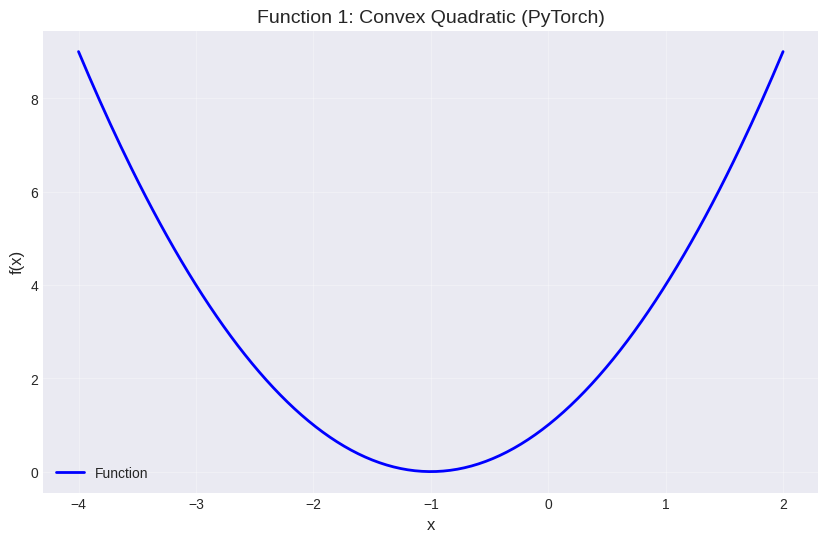

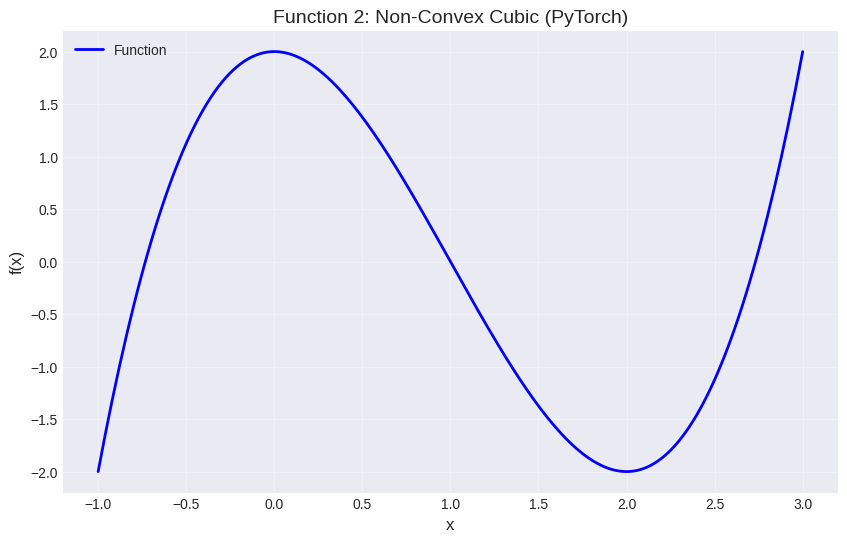

/tmp/ipython-input-455604611.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x**2 + 2*y**2 + 2*x - 4*y + 5)
/tmp/ipython-input-458893728.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


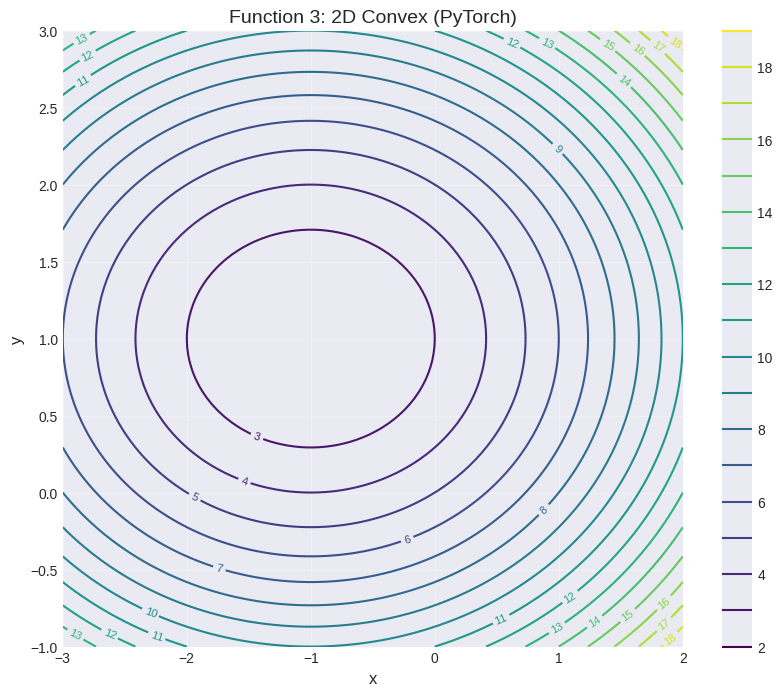

In [23]:
def plot_1d_function_torch(f: Callable, x_range: Tuple[float, float],
                           trajectory: List[float] = None, title: str = ""):
    """Plot a 1D function and optionally show optimization trajectory"""
    x_np = np.linspace(x_range[0], x_range[1], 200)
    y_np = []
    for xi in x_np:
        x_tensor = torch.tensor(xi, requires_grad=False)
        y_np.append(f(x_tensor).item())

    plt.figure(figsize=(10, 6))
    plt.plot(x_np, y_np, 'b-', linewidth=2, label='Function')

    if trajectory:
        traj_y = []
        for xi in trajectory:
            if isinstance(xi, torch.Tensor):
                xi = xi.item()
            x_tensor = torch.tensor(xi, requires_grad=False)
            traj_y.append(f(x_tensor).item())

        traj_x = [x.item() if isinstance(x, torch.Tensor) else x for x in trajectory]
        plt.plot(traj_x, traj_y, 'ro-', markersize=8, linewidth=1.5,
                alpha=0.7, label='Optimization path')
        plt.plot(traj_x[0], traj_y[0], 'go', markersize=12, label='Start')
        plt.plot(traj_x[-1], traj_y[-1], 'r*', markersize=15, label='End')

    plt.xlabel('x', fontsize=12)
    plt.ylabel('f(x)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_2d_function_torch(f: Callable, x_range: Tuple[float, float],
                          y_range: Tuple[float, float], trajectory: List = None,
                          title: str = ""):
    """Plot a 2D function as contour plot with optional trajectory"""
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = torch.tensor([X[i, j], Y[i, j]], requires_grad=False)
            Z[i, j] = f(point).item()

    plt.figure(figsize=(10, 8))
    contour = plt.contour(X, Y, Z, levels=20, cmap='viridis')
    plt.clabel(contour, inline=True, fontsize=8)
    plt.colorbar(contour)

    if trajectory is not None and len(trajectory) > 0:
        traj_np = np.array([[p[0].item() if isinstance(p[0], torch.Tensor) else p[0],
                            p[1].item() if isinstance(p[1], torch.Tensor) else p[1]]
                           for p in trajectory])
        plt.plot(traj_np[:, 0], traj_np[:, 1], 'ro-', markersize=8,
                linewidth=2, alpha=0.7, label='Optimization path')
        plt.plot(traj_np[0, 0], traj_np[0, 1], 'go', markersize=12, label='Start')
        plt.plot(traj_np[-1, 0], traj_np[-1, 1], 'r*', markersize=15, label='End')

    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Visualize all three functions
if f1_tensor is not None:
    plot_1d_function_torch(f1_tensor, (-4, 2), title="Function 1: Convex Quadratic (PyTorch)")
if f2_tensor is not None:
    plot_1d_function_torch(f2_tensor, (-1, 3), title="Function 2: Non-Convex Cubic (PyTorch)")
if f3_tensor is not None:
    plot_2d_function_torch(f3_tensor, (-3, 2), (-1, 3), title="Function 3: 2D Convex (PyTorch)")

## Section 2: Gradient Descent with Autograd

Now let's implement gradient descent using PyTorch's automatic differentiation.

Starting point: 2.0
Final point: -1.0000
Expected minimum: -1.0
Number of steps: 51


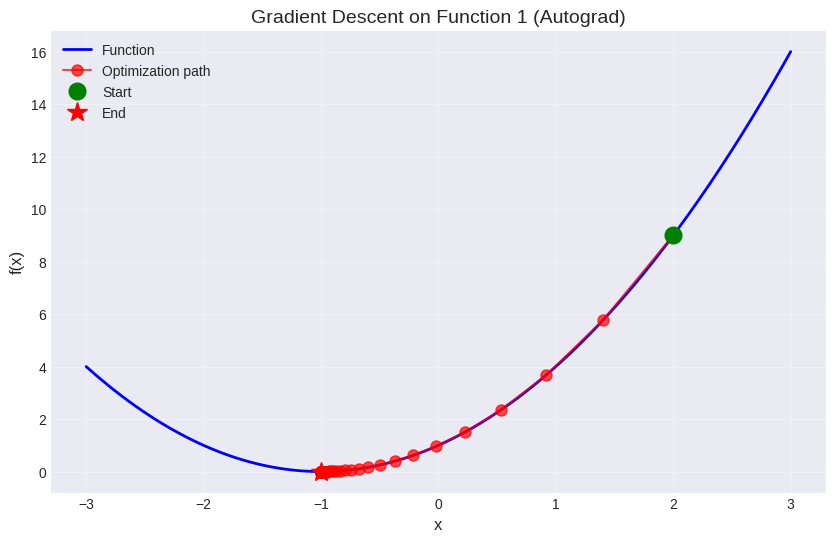

In [66]:
# TODO: Implement gradient descent for 1D functions using autograd
def gradient_descent_torch_1d(f: Callable, x0: float,
                              learning_rate: float, n_iterations: int) -> Tuple[float, List[float]]:
    """
    Gradient descent for 1D functions using PyTorch autograd

    Args:
        f: Function to minimize (takes torch.Tensor, returns torch.Tensor)
        x0: Starting point (float)
        learning_rate: Step size for updates
        n_iterations: Number of iterations

    Returns:
        Tuple of (final_x, trajectory)
        - final_x: Final position after optimization (float)
        - trajectory: List of x values at each iteration
    """
    trajectory = [x0]
    x = torch.tensor(x0, requires_grad=True)

    # TODO: Implement the gradient descent loop
    # For each iteration:
    #   1. Compute function value: y = f(x)
    #   2. Compute gradient using backward(): y.backward()
    #   3. Update x using: x.data = x.data - learning_rate * x.grad
    #   4. Clear gradients: x.grad.zero_()
    #   5. Store current x value in trajectory

    for _ in range(n_iterations):
      y = f(x)
      y.backward()
      x.data = x.data - learning_rate * x.grad
      x.grad.zero_()
      trajectory.append(x.item())

    return x.item(), trajectory

# Test gradient descent on Function 1
if gradient_descent_torch_1d is not None and f1_tensor is not None:
    result_1d, trajectory_1d = gradient_descent_torch_1d(f1_tensor, x0=2.0,
                                                         learning_rate=0.1, n_iterations=50)
    if result_1d is not None:
        print(f"Starting point: 2.0")
        print(f"Final point: {result_1d:.4f}")
        print(f"Expected minimum: -1.0")
        print(f"Number of steps: {len(trajectory_1d)}")

        # Visualize the optimization
        plot_1d_function_torch(f1_tensor, (-3, 3), trajectory_1d,
                              "Gradient Descent on Function 1 (Autograd)")

In [ ]:
# Test Section 2: Gradient Descent 1D
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE2_SECTIONS["Section 2: Gradient Descent with Autograd"] if "1d" in name]
test_runner.test_section("Gradient Descent 1D with Autograd", validator, section_tests, locals())

Starting point: [2.0, 2.0]
Final point: [-1.0000, 1.0000]
Expected minimum: [-1.0, 1.0]
Number of steps: 51


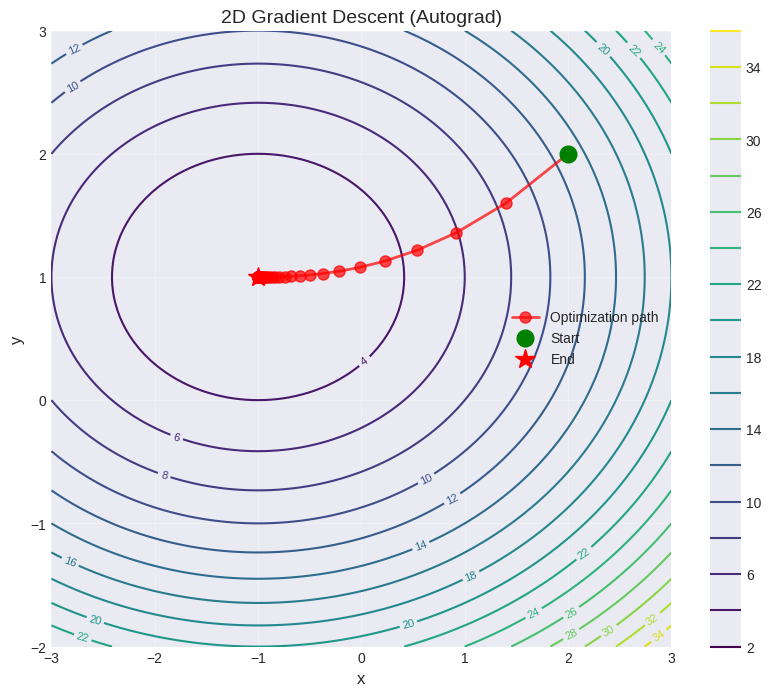

In [26]:
# TODO: Implement gradient descent for multi-dimensional functions using autograd
def gradient_descent_torch_nd(f: Callable, x0: torch.Tensor,
                              learning_rate: float, n_iterations: int) -> Tuple[torch.Tensor, List[torch.Tensor]]:
    """
    Gradient descent for n-dimensional functions using PyTorch autograd

    Args:
        f: Function to minimize
        x0: Starting point (torch.Tensor)
        learning_rate: Step size for updates
        n_iterations: Number of iterations

    Returns:
        Tuple of (final_x, trajectory)
        - final_x: Final position after optimization
        - trajectory: List of positions at each iteration
    """
    trajectory = [x0.clone()]
    x = x0.clone().requires_grad_(True)

    # TODO: Implement the gradient descent loop
    # Similar to 1D case but working with tensors
    for _ in range(n_iterations):
      y = f(x)
      y.backward()
      x.data = x.data - learning_rate * x.grad
      x.grad.zero_()
      trajectory.append(x.clone())

    return x.clone(), trajectory

# Test gradient descent on Function 3 (2D)
if gradient_descent_torch_nd is not None and f3_tensor is not None:
    result_nd, trajectory_nd = gradient_descent_torch_nd(f3_tensor,
                                                         x0=torch.tensor([2.0, 2.0]),
                                                         learning_rate=0.1,
                                                         n_iterations=50)
    if result_nd is not None:
        print(f"Starting point: [2.0, 2.0]")
        print(f"Final point: [{result_nd[0]:.4f}, {result_nd[1]:.4f}]")
        print(f"Expected minimum: [-1.0, 1.0]")
        print(f"Number of steps: {len(trajectory_nd)}")

        # Visualize the optimization
        plot_2d_function_torch(f3_tensor, (-3, 3), (-2, 3), trajectory_nd,
                              "2D Gradient Descent (Autograd)")

In [ ]:
# Test Section 2: Gradient Descent ND
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE2_SECTIONS["Section 2: Gradient Descent with Autograd"] if "nd" in name]
test_runner.test_section("Gradient Descent ND with Autograd", validator, section_tests, locals())

## Section 3: PyTorch Optimizers

PyTorch provides built-in optimizers that handle the gradient updates for us. Let's explore SGD and Adam.

In [53]:
import torch
import torch.optim as optim

# TODO: Set up SGD optimizer
# Create a parameter to optimize and an SGD optimizer
x_params = torch.tensor(2.0, requires_grad=True)  # TODO: Create a tensor with requires_grad=True, starting at x=2.0

sgd_optimizer = torch.optim.SGD([x_params], lr=0.1)  # TODO: Create torch.optim.SGD optimizer with learning rate 0.1 that will optimize x

y = x_params**2 # TODO: define function y = x^2

# TODO: apply optimizer step
# Clear any existing gradients .zero_grad()
# Compute gradients (dy/dx = 2x) .backward()
# Update x_params using gradients .step()
sgd_optimizer.zero_grad()
y.backward() # il faut le backward pour que la step de l'optimizer se fasse
sgd_optimizer.step()
# Display new params

print(f"Original x: 2.0")
print(f"New x after one SGD step: {x_params.item():.4f}")
print(f"Gradient was: {x_params.grad.item():.4f}")
print(f"New y = x^2: {(x_params ** 2).item():.4f}")

Original x: 2.0
New x after one SGD step: 1.6000
Gradient was: 4.0000
New y = x^2: 2.5600


In [58]:
# TODO: Do the same with torch.optim.Adam optimizer
x_params = torch.tensor(2.0, requires_grad=True)  # TODO: Create a tensor with requires_grad=True, starting at x=2.0

adam_optimizer = torch.optim.SGD([x_params], lr=0.1)  # TODO: Create torch.optim.SGD optimizer with learning rate 0.1 that will optimize x

y = x_params**2 # TODO: define function y = x^2

# TODO: apply optimizer step
# Clear any existing gradients .zero_grad()
# Compute gradients (dy/dx = 2x) .backward()
# Update x_params using gradients .step()

adam_optimizer.zero_grad()
y.backward()
adam_optimizer.step()

print(f"Original x: 2.0")
print(f"New x after one SGD step: {x_params.item():.4f}")
print(f"Gradient was: {x_params.grad.item():.4f}")
print(f"New y = x^2: {(x_params ** 2).item():.4f}")

Original x: 2.0
New x after one SGD step: 1.6000
Gradient was: 4.0000
New y = x^2: 2.5600


In [ ]:
# Test Section 3: Optimizer Setup
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE2_SECTIONS["Section 3: PyTorch Optimizers"] if "sgd" in name or "adam" in name]
test_runner.test_section("PyTorch Optimizer Setup", validator, section_tests, locals())

SGD Final position: -1.0000


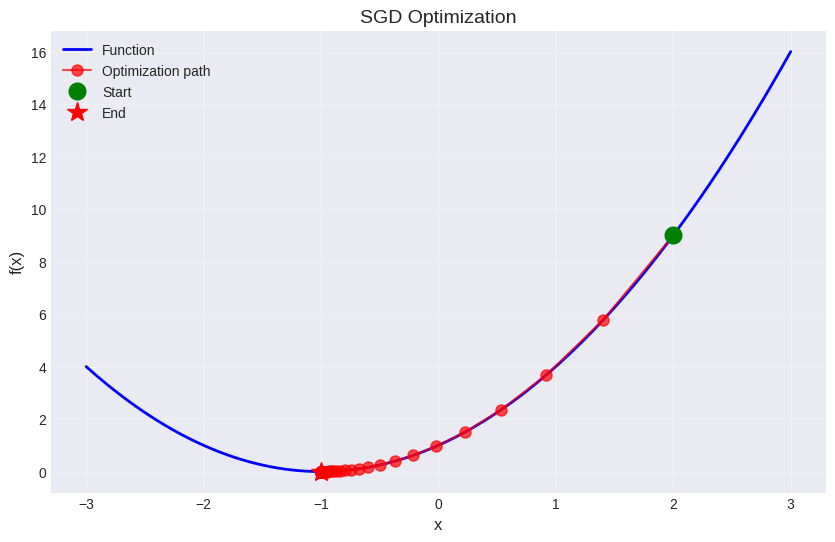

Adam Final position: -1.1689


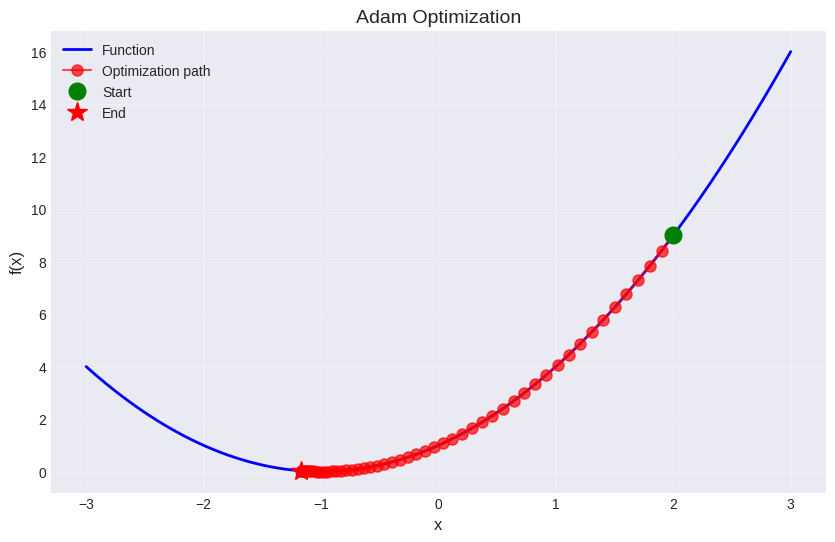

In [61]:
# TODO: Implement optimization using PyTorch optimizers
def optimize_with_pytorch(f: Callable, x0: torch.Tensor, optimizer: torch.optim.Optimizer,
                          n_iterations: int) -> Tuple[torch.Tensor, List[torch.Tensor]]:
    """
    Optimize a function using a PyTorch optimizer

    Args:
        f: Function to minimize
        x0: Starting point (should be the parameter in the optimizer)
        optimizer: PyTorch optimizer
        n_iterations: Number of iterations

    Returns:
        Tuple of (final_x, trajectory)
    """
    trajectory = [x0.clone().detach()]

    # TODO: Implement the optimization loop
    # For each iteration:
    #   1. Zero gradients: optimizer.zero_grad()
    #   2. forward : f(x0)
    #   3. Compute gradients: loss.backward()
    #   4. Update parameters: optimizer.step()
    #   5. Store current position in trajectory

    for _ in range(n_iterations):
      optimizer.zero_grad()
      y = f(x0)
      y.backward()
      optimizer.step()
      trajectory.append(x0.clone().detach())

    return trajectory[-1], trajectory

# Test with SGD
if optimize_with_pytorch is not None and f1_tensor is not None:
    sgd_x = torch.tensor(2.0, requires_grad=True)
    sgd_opt = torch.optim.SGD([sgd_x], lr=0.1)

    result_sgd, traj_sgd = optimize_with_pytorch(f1_tensor, sgd_x, sgd_opt, 50)
    if result_sgd is not None:
        print(f"SGD Final position: {result_sgd.item():.4f}")
        plot_1d_function_torch(f1_tensor, (-3, 3), traj_sgd, "SGD Optimization")

    # Test with Adam
    adam_x = torch.tensor(2.0, requires_grad=True)
    adam_opt = torch.optim.Adam([adam_x], lr=0.1)

    result_adam, traj_adam = optimize_with_pytorch(f1_tensor, adam_x, adam_opt, 50)
    if result_adam is not None:
        print(f"Adam Final position: {result_adam.item():.4f}")
        plot_1d_function_torch(f1_tensor, (-3, 3), traj_adam, "Adam Optimization")

In [ ]:
# Test Section 3: Optimization with PyTorch
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE2_SECTIONS["Section 3: PyTorch Optimizers"] if "optimize_with_pytorch" in name]
test_runner.test_section("Optimization with PyTorch Optimizers", validator, section_tests, locals())

## Section 4: Advanced Optimization

Let's explore momentum and learning rate scheduling.

### Momentum Comparison

In [63]:
# TODO: Compare SGD with and without momentum
momentum_results = {}

# TODO: Run SGD without momentum
x_no_momentum = torch.tensor(3.0, requires_grad=True)
optimizer_no_momentum = torch.optim.SGD([x_no_momentum], lr=0.01)

# Track convergence
converged = False
iteration = 0
max_iterations = 200
tolerance = 1e-4
prev_x = float('inf')

while not converged and iteration < max_iterations:
    # TODO: Perform one optimization step
    # Check convergence: |x_new - x_old| < tolerance
    optimizer_no_momentum.zero_grad()
    y = f1_tensor(prev_x)
    if torch.abs(y - prev_x) < tolerance:
        converged = True

    y.backward()
    optimizer_no_momentum.step()
    prev_x = y.item()

    iteration += 1

momentum_results["no_momentum"] = {
    "final": prev_x,  # TODO: Set final x value
    "iterations": iteration  # TODO: Set number of iterations to converge
}

# TODO: Run SGD with momentum
x_with_momentum = torch.tensor(3.0, requires_grad=True)
optimizer_with_momentum = torch.optim.SGD([x_with_momentum], lr=0.01, momentum=0.9)

# Track convergence (similar to above)
# TODO: Implement the optimization loop with momentum

momentum_results["with_momentum"] = {
    "final": None,  # TODO: Set final x value
    "iterations": None  # TODO: Set number of iterations to converge
}

# Display results
if momentum_results["no_momentum"]["iterations"] is not None:
    print("Without Momentum:")
    print(f"  Converged in {momentum_results['no_momentum']['iterations']} iterations")
    print(f"  Final value: {momentum_results['no_momentum']['final']}")

if momentum_results["with_momentum"]["iterations"] is not None:
    print("\nWith Momentum:")
    print(f"  Converged in {momentum_results['with_momentum']['iterations']} iterations")
    print(f"  Final value: {momentum_results['with_momentum']['final']}")

    if momentum_results["no_momentum"]["iterations"] is not None:
        speedup = momentum_results["no_momentum"]["iterations"] / momentum_results["with_momentum"]["iterations"]
        print(f"\nSpeedup: {speedup:.2f}x faster with momentum")

TypeError: abs(): argument 'input' (position 1) must be Tensor, not float

In [ ]:
# Test Section 4: Momentum Comparison
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE2_SECTIONS["Section 4: Advanced Optimization"] if "momentum" in name]
test_runner.test_section("Momentum Comparison", validator, section_tests, locals())

## Interactive Experiments

Try different optimizers and hyperparameters on various functions.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

def compare_optimizers(f: Callable, x0, n_iterations: int = 100):
    """Compare different optimizers on the same problem"""

    # Convert x0 to tensor if it isn't already
    if not isinstance(x0, torch.Tensor):
        x0_tensor = torch.tensor(x0, dtype=torch.float32)
    else:
        x0_tensor = x0.clone()

    optimizers = {
        "SGD (lr=0.01)": lambda x: torch.optim.SGD([x], lr=0.01),
        "SGD (lr=0.1)": lambda x: torch.optim.SGD([x], lr=0.1),
        "SGD + Momentum": lambda x: torch.optim.SGD([x], lr=0.01, momentum=0.9),
        "Adam": lambda x: torch.optim.Adam([x], lr=0.01),
        "RMSprop": lambda x: torch.optim.RMSprop([x], lr=0.01),
    }

    results = {}

    for name, opt_fn in optimizers.items():
        x = x0_tensor.clone().requires_grad_(True)
        optimizer = opt_fn(x)

        trajectory = [x.detach().clone()]
        forwards = []

        for i in range(n_iterations):
            optimizer.zero_grad()
            forward = f(x)
            forward.backward()
            optimizer.step()

            trajectory.append(x.detach().clone())
            forwards.append(forward.item())

        results[name] = {
            "final": x.detach().clone(),
            "trajectory": trajectory,
            "forwards": forwards
        }

    # Plot forward convergence only
    plt.figure(figsize=(10, 6))

    for name, data in results.items():
        plt.plot(data["forwards"], label=name, linewidth=2)

    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Forward', fontsize=12)
    plt.title('Forward Convergence Comparison', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

    # Print final results
    print("Final positions:")
    for name, data in results.items():
        if data['final'].numel() == 1:
            print(f"  {name}: {data['final'].item():.6f}")
        else:
            print(f"  {name}: norm = {torch.norm(data['final']).item():.6f}")

In [ ]:
# 1. SIMPLE QUADRATIC (1D)
def quadratic_1d(x):
    """Simple quadratic: (x - 2)^2"""
    return (x - 2)**2

# 2. SHIFTED QUADRATIC (1D)
def shifted_quadratic(x):
    """Shifted quadratic with minimum at x = -3"""
    return (x + 3)**2 + 5

# 3. ROSENBROCK FUNCTION (2D) - Classic optimization test
def rosenbrock_2d(x):
    """Rosenbrock function: (1-x1)^2 + 100*(x2-x1^2)^2"""
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

# 4. BEALE FUNCTION (2D) - Multimodal
def beale_function(x):
    """Beale function - has multiple local minima"""
    return ((1.5 - x[0] + x[0]*x[1])**2 +
            (2.25 - x[0] + x[0]*x[1]**2)**2 +
            (2.625 - x[0] + x[0]*x[1]**3)**2)

# 5. SPHERE FUNCTION (N-D) - Simple convex
def sphere_function(x):
    """Sum of squares: sum(xi^2)"""
    return torch.sum(x**2)

# 6. RASTRIGIN FUNCTION (N-D) - Highly multimodal
def rastrigin_function(x):
    """Rastrigin function - many local minima"""
    A = 10
    n = x.shape[0] if len(x.shape) > 0 else 1
    return A * n + torch.sum(x**2 - A * torch.cos(2 * np.pi * x))

# 7. ACKLEY FUNCTION (N-D) - Complex landscape
def ackley_function(x):
    """Ackley function - complex multimodal"""
    if len(x.shape) == 0:
        x = x.unsqueeze(0)
    n = x.shape[0]
    sum1 = torch.sum(x**2)
    sum2 = torch.sum(torch.cos(2 * np.pi * x))
    return -20 * torch.exp(-0.2 * torch.sqrt(sum1 / n)) - torch.exp(sum2 / n) + 20 + torch.e

def nn_loss_simulation(x):
    """Simulates a neural network loss landscape"""
    # Create some "weight matrices" effect
    n = x.shape[0] if len(x.shape) > 0 else 1

    # L2 regularization term
    l2_term = 0.01 * torch.sum(x**2)

    # Simulate some non-convex interactions
    interaction_term = torch.sum(torch.sin(x) * torch.cos(x * 1.5))

    # Quadratic bowl with noise
    quadratic_term = torch.sum((x - 0.5)**2)

    return quadratic_term + interaction_term + l2_term

In [ ]:
# Test 1: Simple 1D Quadratic
print("\n1. Simple Quadratic (1D)")
print("-" * 30)
compare_optimizers(quadratic_1d, 10.0, n_iterations=50)

# Test 2: Shifted Quadratic (1D)
print("\n2. Shifted Quadratic (1D)")
print("-" * 30)
compare_optimizers(shifted_quadratic, 5.0, n_iterations=50)

# Test 3: Rosenbrock (2D) - Classic test
print("\n3. Rosenbrock Function (2D)")
print("-" * 30)
compare_optimizers(rosenbrock_2d, torch.tensor([0.0, 0.0]), n_iterations=200)

# Test 4: Beale Function (2D) - Multimodal
print("\n4. Beale Function (2D)")
print("-" * 30)
compare_optimizers(beale_function, torch.tensor([1.0, 1.0]), n_iterations=200)

# Test 5: Sphere Function (5D) - Medium dimension
print("\n5. Sphere Function (5D)")
print("-" * 30)
compare_optimizers(sphere_function, torch.randn(5), n_iterations=100)

# Test 6: Rastrigin (10D) - High dimension, multimodal
print("\n6. Rastrigin Function (10D)")
print("-" * 30)
compare_optimizers(rastrigin_function, torch.randn(10), n_iterations=300)

# Test 7: Ackley (20D) - Very high dimension
print("\n7. Ackley Function (20D)")
print("-" * 30)
compare_optimizers(ackley_function, torch.randn(20), n_iterations=300)

# Test 8: NN Loss Simulation (100D) - Very high dimension
print("\n8. Neural Network Loss Simulation (100D)")
print("-" * 30)
compare_optimizers(nn_loss_simulation, torch.randn(100), n_iterations=500)


In [ ]:
# TODO:
# Create your customs functions (be creative) and try to minimize them with different optimizers